In [1]:
import time
import os
import sys
import numpy as np

import uncertainties

#import ipympl
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')

import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import *
from mmtwfs.telescope import MMT

from pathlib import Path
from astropy.modeling import models, fitting

%load_ext autoreload
%autoreload 2

import lmfit

In [2]:
plt.close('all')
home = Path(os.environ['HOME'])
mmirs = WFSFactory(wfs="mmirs", nzern=21)
f9wfs = WFSFactory(wfs="newf9", nzern=21)
f5wfs = WFSFactory(wfs="f5", nzern=21)

<IPython.core.display.Javascript object>


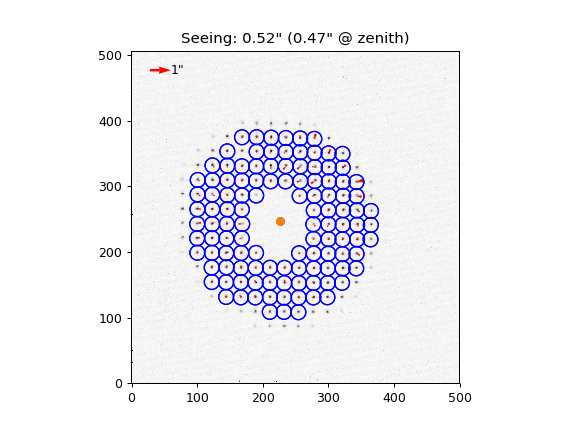

In [3]:
mmirs_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/mmirs_wfs_0150.fits"
mmirs_results = mmirs.measure_slopes(mmirs_file, plot=True)
mmirs_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


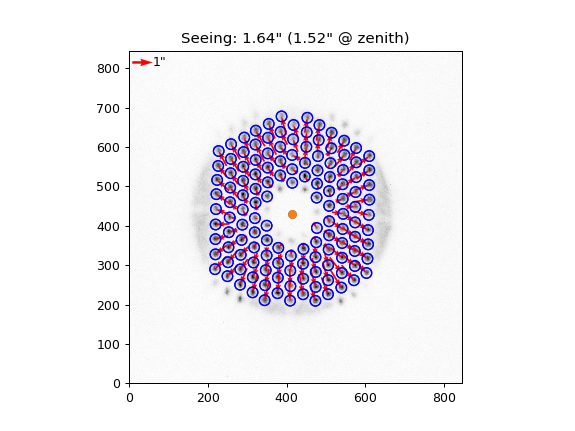

In [4]:
f9_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/test_newf9.fits"
f9_results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
f9_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


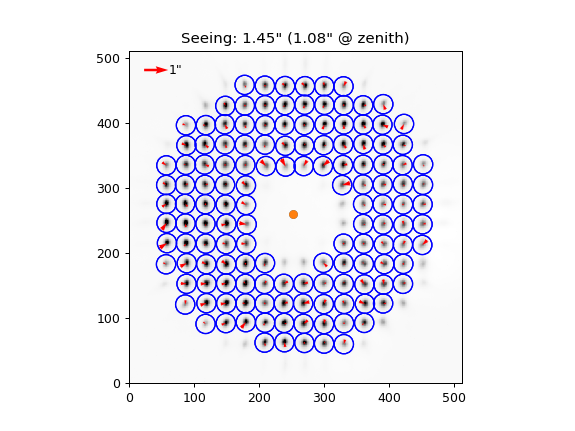

In [5]:
f5_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/auto_wfs_0037_ave.fits"
f5_results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
f5_results['figures']['slopes'].show()

In [14]:
def make_init_pars(nmodes=21, modestart=2, init_zv=None):
    pars = []
    for i in range(modestart, modestart+nmodes, 1):
        key = "Z{:02d}".format(i)
        if init_zv is not None:
            val = init_zv[key].value
            if val < 1.e-4:
                val = 0.0
        else:
            val = 0.0
        zpar = (key, val)
        pars.append(zpar)
    params = lmfit.Parameters()
    params.add_many(*pars)
    return params

In [7]:
def zernike_slopes(parsdict, rho, phi, norm=False):
    xslope = 0.
    yslope = 0.
    for k, v in parsdict.items():
        l = int(k.replace("Z", ""))
        dwx, dwy = zernike_slope_noll(l, rho, phi, norm=norm)
        xslope += v * dwx
        yslope += v * dwy
    return xslope, yslope

In [8]:
def slope_chisq(pars, coords, slopes, norm=False):
    parsdict = pars.valuesdict()
    rho, phi = cart2pol(coords)
    xslope = slopes[0]
    yslope = slopes[1]
    pred_xslope, pred_yslope = zernike_slopes(parsdict, rho, phi, norm=norm)
    dist = np.sqrt((xslope - pred_xslope)**2 + (yslope - pred_yslope)**2)
    return dist

In [10]:
slopes = -f9wfs.tiltfactor * f9_results['slopes']
pup_coords = f9wfs.modes['blue']['reference'].pup_coords(f9wfs.pup_size/2.)

In [11]:
slopes = -f5wfs.tiltfactor * f5_results['slopes']
pup_coords = f5wfs.modes['hecto']['reference'].pup_coords(f5wfs.pup_size/2.)

In [15]:
params = make_init_pars(nmodes=21, init_zv=f5wfs.reference_aberrations('hecto'))
out = lmfit.minimize(slope_chisq, params, args=(pup_coords, slopes))
print(lmfit.fit_report(out))

Missing WFS header. Assuming data is acquired on-axis.


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 450
    # data points      = 151
    # variables        = 21
    chi-square         = 7.0537e+08
    reduced chi-square = 5425955.45
    Akaike info crit   = 2360.90084
    Bayesian info crit = 2424.26371
[[Variables]]
    Z02:  215.612745 +/- 362.343342 (168.05%) (init = 0)
    Z03:  248.581872 +/- 363.233801 (146.12%) (init = 0)
    Z04: -2570.67628 +/- 112.473170 (4.38%) (init = 0)
    Z05:  170.891862 +/- 228.340106 (133.62%) (init = 0)
    Z06:  676.580706 +/- 240.722018 (35.58%) (init = 0.083)
    Z07: -170.932093 +/- 155.381127 (90.90%) (init = 0.269)
    Z08: -221.624819 +/- 174.652613 (78.81%) (init = 0)
    Z09: -46.2367404 +/- 205.325292 (444.07%) (init = 0)
    Z10:  174.194040 +/- 190.877428 (109.58%) (init = 0)
    Z11: -355.539114 +/- 90.3487983 (25.41%) (init = 0)
    Z12: -102.711599 +/- 106.673658 (103.86%) (init = 0)
    Z13:  57.0593791 +/- 102.772924 (180.12%) (init = 0)
    Z14:  179.9635

In [16]:
zvec = ZernikeVector(coeffs=out) - f5wfs.reference_aberrations('hecto')
#zvec.units = u.m
zvec['Z23'] = 10.
print(zvec.pretty_print(last=37))

Missing WFS header. Assuming data is acquired on-axis.


Fringe Coefficients
 Z02:         215.6 ±   362 nm 	 X Tilt (1, 1)
 Z03:         248.6 ±   363 nm 	 Y Tilt (1, -1)
 Z04:         201.7 ±   195 nm 	 Defocus (2, 0)
 Z05:         170.9 ±   395 nm 	 Primary Astig at 45° (2, -2)
 Z06:         676.5 ±   417 nm 	 Primary Astig at 0° (2, 2)
 Z07:        -171.2 ±   269 nm 	 Primary Y Coma (3, -1)
 Z08:        -221.6 ±   303 nm 	 Primary X Coma (3, 1)
 Z09:        -46.23 ±   356 nm 	 Y Trefoil (3, -3)
 Z10:         174.2 ±   331 nm 	 X Trefoil (3, 3)
 Z11:          -138 ±   156 nm 	 Primary Spherical (4, 0)
 Z12:        -102.7 ±   107 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:         57.06 ±   103 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:           180 ±   161 nm 	 X Tetrafoil (4, 4)
 Z15:         219.5 ±   157 nm 	 Y Tetrafoil (4, -4)
 Z16:         15.69 ±   112 nm 	 Secondary X Coma (5, 1)
 Z17:         121.3 ±   101 nm 	 Secondary Y Coma (5, -1)
 Z18:         5.197 ±  91.2 nm 	 Secondary X Trefoil (5, 3)
 Z19:        -6.904 ±   101

<IPython.core.display.Javascript object>


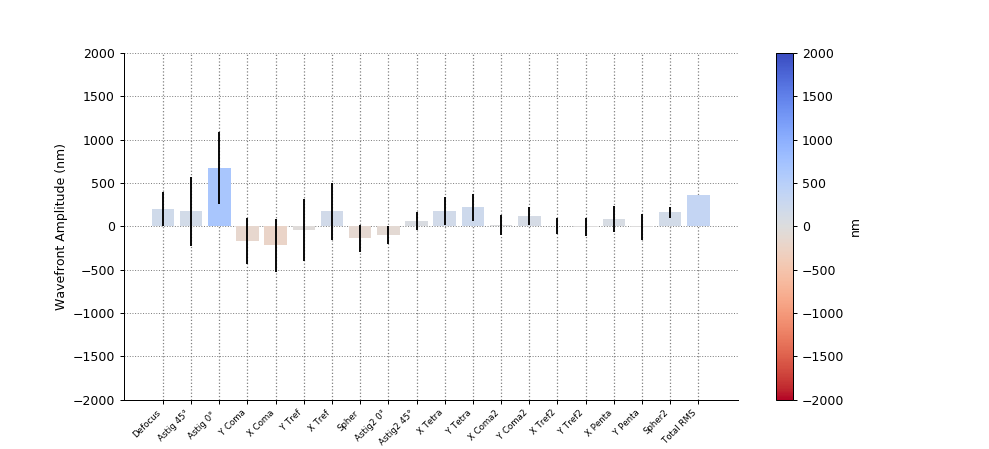

In [17]:
zvec.fringe_bar_chart().show()

In [ ]:
for p, v in out.params.items():
    print(v.stderr)

In [ ]:
(1 * u.nm)**1.3

In [ ]:
zvec.coeffs

In [ ]:
zresults = f9wfs.fit_wavefront(f9_results, plot=True)
print(zresults['residual_rms'])
print(zresults['raw_zernike'].pretty_print())
zresults['resid_plot'].show()

In [ ]:
"{0:>0.04g} +/- {1:0.04g}".format(zvec['Z04'].value, zvec['Z09'])

In [ ]:
testdata, hdr = check_wfsdata("/Users/tim/mmirs_wfs_0120.fits", header=True)

In [ ]:
mmirs.reference_aberrations('mmirs1', hdr=hdr)

In [ ]:
610/40.8

In [ ]:
np.sqrt((415/3)**2 + (1528/3)**2)

In [ ]:
np.sqrt(67**2 + 7**2)

In [ ]:
mmirs.focal_plane_position(hdr)

In [ ]:
zvec = mmirs.reference_aberrations('mmirs1', hdr=hdr)
zvec

In [ ]:
zvec.rotate(angle=-90*u.deg)
zvec

In [ ]:
from uncertainties import ufloat

In [ ]:
u.Quantity(ufloat(100., 10.), u.nm)

In [ ]:
import unyt

In [ ]:
type(ufloat(100., 10.))

In [ ]:
u.Quantity(ufloat(100., 10.), u.nm)

In [ ]:
def ZernikeGrad(zpars, x, y, atype):
    if(len(zpars) > 21):
        print('ZernikeGrad() is not implemented with >21 terms')
        return

    x2 = x * x
    y2 = y * y
    xy = x * y
    r2 = x2 + y2

    if (atype == 'dx'):
        d = 0. * x  # to make d an array with the same size as x
        d = d + zpars['Z02'] * 1.
        d = d + zpars['Z03'] * 0.
        d = d + zpars['Z04'] * 4. * x
        d = d + zpars['Z05'] * 2. * y
        d = d + zpars['Z06'] * 2. * x
        d = d + zpars['Z07'] * 6. * xy
        d = d + zpars['Z08'] * (9. * x2 + 3. * y2 - 2.)
        d = d + zpars['Z09'] * 6. * xy
        d = d + zpars['Z10'] * (3. * x2 - 3. * y2)
        d = d + zpars['Z11'] * 12. * x * (2. * (x2 + y2) - 1.)
        d = d + zpars['Z12'] * x * (16. * x2 - 6.)
        d = d + zpars['Z13'] * y * (24. * x2 + 8. * y2 - 6.)
        d = d + zpars['Z14'] * 4. * x * (x2 - 3. * y2)
        d = d + zpars['Z15'] * 4. * y * (3. * x2 - y2)
        d = d + zpars['Z16'] * (x2 * (50. * x2 + 60. * y2 - 36.) + y2 * (10. * y2 - 12.) + 3.)
        d = d + zpars['Z17'] * (xy * (40. * r2 - 24.))
        d = d + zpars['Z18'] * (x2 * (25. * x2 - 12. - 30. * y2) + y2 * (12. - 15. * y2))
        d = d + zpars['Z19'] * (4. * xy * (-6. + 15. * x2 + 5. * y2))
        d = d + zpars['Z20'] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + zpars['Z21'] * 20. * xy * (x2 - y2)
        d = d + zpars['Z22'] * 24. * x * (1. + x2 * (10. * y2 - 5. + 5. * x2) + y2 * (5. * y2 - 5.))

    elif (atype, 'dy'):

        d = 0. * y
        d = d + zpars['Z02'] * 0.
        d = d + zpars['Z03'] * 1.
        d = d + zpars['Z04'] * 4. * y
        d = d + zpars['Z05'] * 2. * x
        d = d + zpars['Z06'] * (-2.) * y
        d = d + zpars['Z07'] * (3. * x2 + 9. * y2 - 2.)
        d = d + zpars['Z08'] * 6. * xy
        d = d + zpars['Z09'] * (3. * x2 - 3. * y2)
        d = d + zpars['Z10'] * (-6.) * xy
        d = d + zpars['Z11'] * 12. * y * (2. * (x2 + y2) - 1.)
        d = d + zpars['Z12'] * y * (6. - 16. * y2)
        d = d + zpars['Z13'] * x * (8. * x2 + 24. * y2 - 6.)
        d = d + zpars['Z14'] * 4. * y * (y2 - 3. * x2)
        d = d + zpars['Z15'] * 4. * x * (x2 - 3. * y2)
        d = d + zpars['Z16'] * (xy * (40. * r2 - 24.))
        d = d + zpars['Z17'] * (x2 * (10. * x2 + 60. * y2 - 12.) + y2 * (50. * y2 - 36.) + 3.)
        d = d + zpars['Z18'] * (4. * xy * (6. - 5. * x2 - 15. * y2))
        d = d + zpars['Z19'] * (y2 * (-25. * y2 + 12. + 30. * x2) + x2 * (-12. + 15. * x2))
        d = d + zpars['Z20'] * 20. * xy * (y2 - x2)
        d = d + zpars['Z21'] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + zpars['Z22'] * 24. * y * (1. + y2 * (10. * x2 - 5. + 5. * y2) + x2 * (5. * x2 - 5.))

    return d

In [ ]:
x = uncertainties.ufloat(10, 2)
xarr = np.array([x, x])

In [ ]:
xu = UQuantity(x, u.mm)

In [ ]:
"{0:0.6g}".format(xu)

In [ ]:
xuarr = UQuantity(xarr, u.mm)

In [ ]:
z = ZernikeVector(Z04=1000*u.nm)

In [ ]:
z['Z15']

In [ ]:
getattr(xarr, "dtype")

In [ ]:
(1. / u.nm).unit

In [ ]:
len({})

In [ ]:
((1 * u.m) / (2 * u.m)) * 3 * u.m

In [ ]:
d = {}
d.get('a', 0)

In [9]:
f5wfs.reference_aberrations('hecto')

Missing WFS header. Assuming data is acquired on-axis.


Fringe Coefficients
 Z04:                 -2772 nm 	 Defocus (2, 0)
 Z05:             1.016e-17 nm 	 Primary Astig at 45° (2, -2)
 Z06:                 0.083 nm 	 Primary Astig at 0° (2, 2)
 Z07:                 0.269 nm 	 Primary Y Coma (3, -1)
 Z08:            -1.647e-17 nm 	 Primary X Coma (3, 1)
 Z09:                -0.004 nm 	 Y Trefoil (3, -3)
 Z10:             7.348e-19 nm 	 X Trefoil (3, 3)
 Z11:                -217.6 nm 	 Primary Spherical (4, 0)

Total RMS: 	 1604 nm